# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment.

In [1]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 37.72 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 27.4 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214817 sha256=f7ec92f24a02cfff2bbb8cb271c8d83f1a792ee0761dbbfeaa800071b7514d65
  Stored in directory: /root/.cache

# 2. Upload Images

Upload the images to be processed by Real-ESRGAN.

I used the dataset https://github.com/mut-deep/IR-LPR for its license plate number section.

In [2]:
# نصب gdown برای دانلود از گوگل درایو
!pip install gdown -q

# ساخت پوشه‌ها
!mkdir -p /content/IR_LPR_data/all_images
!mkdir -p /content/Real-ESRGAN/upload
!mkdir -p /content/Real-ESRGAN/results

# دانلود هر سه فایل zip
!gdown --id 1ubkg7E2vGEOqS4K_quwf9Vl-i8IVpklM -O /content/IR_LPR_data/file1.zip
!gdown --id 1AL5Zsg2hDqcwF8ZmR0MJTbjgXIoE5W-I -O /content/IR_LPR_data/file2.zip
!gdown --id 1lLh_kxrHy1teUB2NguHVuOZwA5rjL5kx -O /content/IR_LPR_data/file3.zip

# استخراج هر سه فایل در پوشه‌ی all_images
!unzip -q /content/IR_LPR_data/file1.zip -d /content/IR_LPR_data/all_images/
!unzip -q /content/IR_LPR_data/file2.zip -d /content/IR_LPR_data/all_images/
!unzip -q /content/IR_LPR_data/file3.zip -d /content/IR_LPR_data/all_images/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ubkg7E2vGEOqS4K_quwf9Vl-i8IVpklM
From (redirected): https://drive.google.com/uc?id=1ubkg7E2vGEOqS4K_quwf9Vl-i8IVpklM&confirm=t&uuid=f8697d2d-3a83-458d-acec-63b874b231f9
To: /content/IR_LPR_data/file1.zip
100% 196M/196M [00:01<00:00, 176MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AL5Zsg2hDqcwF8ZmR0MJTbjgXIoE5W-I
From (redirected): https://drive.google.com/uc?id=1AL5Zsg2hDqcwF8ZmR0MJTbjgXIoE5W-I&confirm=t&uuid=dc87c5ad-7f5f-4e9c-b0ec-367faae4484d
To: /content/IR_LPR

In [3]:
import os
import shutil
import random
from glob import glob

# مسیر داده‌ها
src_root = '/content/IR_LPR_data/all_images'   # فایل‌های اصلی unzip شده
intermediate_root = '/content/Real-ESRGAN/all_flat'  # پوشه ثانویه
upload_root = '/content/Real-ESRGAN/upload'   # پوشه نهایی upload

# ساخت پوشه‌ها در صورت عدم وجود
os.makedirs(intermediate_root, exist_ok=True)
os.makedirs(upload_root, exist_ok=True)

# دریافت همه فایل‌های jpg از زیرپوشه‌ها
image_paths = glob(os.path.join(src_root, '*', '*.jpg'))

# انتقال تصاویر به پوشه ثانویه
for path in image_paths:
    filename = os.path.basename(path)
    dst_path = os.path.join(intermediate_root, filename)

    base, ext = os.path.splitext(filename)
    counter = 1
    while os.path.exists(dst_path):
        dst_path = os.path.join(intermediate_root, f"{base}_{counter}{ext}")
        counter += 1

    shutil.copy(path, dst_path)

print(f"{len(image_paths)} فایل JPG منتقل شد به پوشه ثانویه: {intermediate_root}")

# انتخاب تصادفی ۳۰٪ تصاویر برای upload
all_intermediate = glob(os.path.join(intermediate_root, '*.jpg'))
selected_count = int(0.3 * len(all_intermediate))
selected_images = random.sample(all_intermediate, selected_count)

# انتقال تصاویر انتخاب شده به پوشه upload
for path in selected_images:
    filename = os.path.basename(path)
    dst_path = os.path.join(upload_root, filename)
    shutil.copy(path, dst_path)

print(f"{len(selected_images)} فایل JPG به صورت رندوم به پوشه upload منتقل شد.")


27745 فایل JPG منتقل شد به پوشه ثانویه: /content/Real-ESRGAN/all_flat
8323 فایل JPG به صورت رندوم به پوشه upload منتقل شد.


# 3. Inference

In [5]:
# if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore.

Streaming output truncated to the last 5000 lines.
Testing 3325 11252
Testing 3326 11253
Testing 3327 11254
Testing 3328 11261
Testing 3329 11262
Testing 3330 11271
Testing 3331 11276
Testing 3332 11278
Testing 3333 11280
Testing 3334 11282
Testing 3335 11284
Testing 3336 11286
Testing 3337 11295
Testing 3338 11296
Testing 3339 11301
Testing 3340 11305
Testing 3341 11306
Testing 3342 11307
Testing 3343 11308
Testing 3344 11317
Testing 3345 11320
Testing 3346 11331
Testing 3347 11338
Testing 3348 11342
Testing 3349 11346
Testing 3350 11347
Testing 3351 11352
Testing 3352 11354
Testing 3353 11360
Testing 3354 11362
Testing 3355 11373
Testing 3356 11374
Testing 3357 11376
Testing 3358 11377
Testing 3359 11378
Testing 3360 11379
Testing 3361 11382
Testing 3362 11383
Testing 3363 11386
Testing 3364 11387
Testing 3365 11390
Testing 3366 11392
Testing 3367 11394
Testing 3368 11398
Testing 3369 11399
Testing 3370 11401
Testing 3371 11408
Testing 3372 11418
Testing 3373 11423
Testing 3374 11424

# 4. Visualization

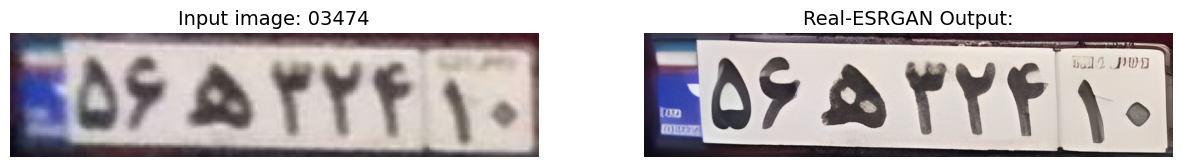

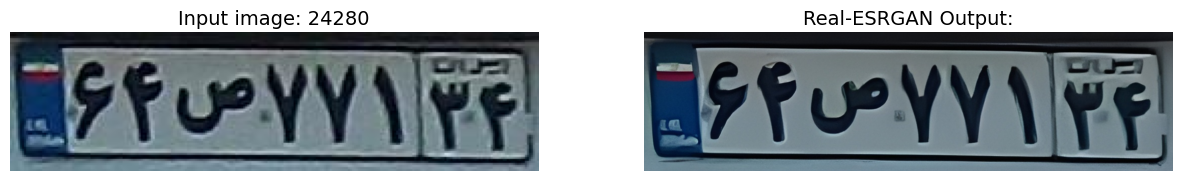

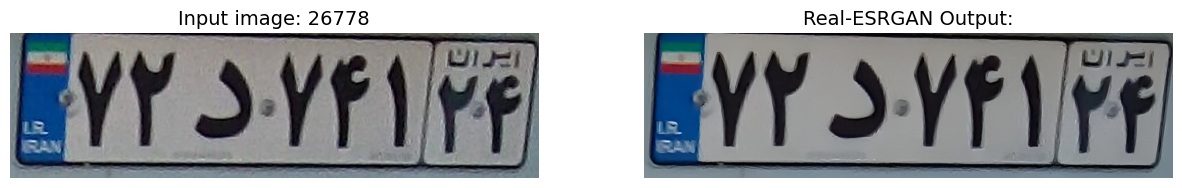

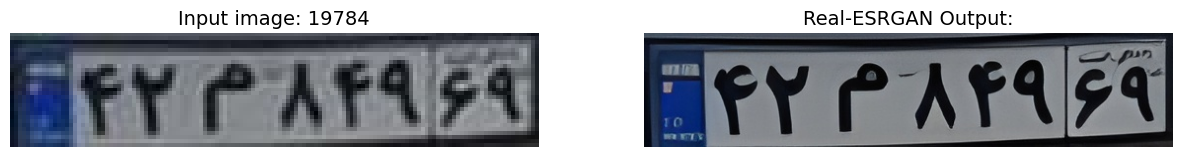

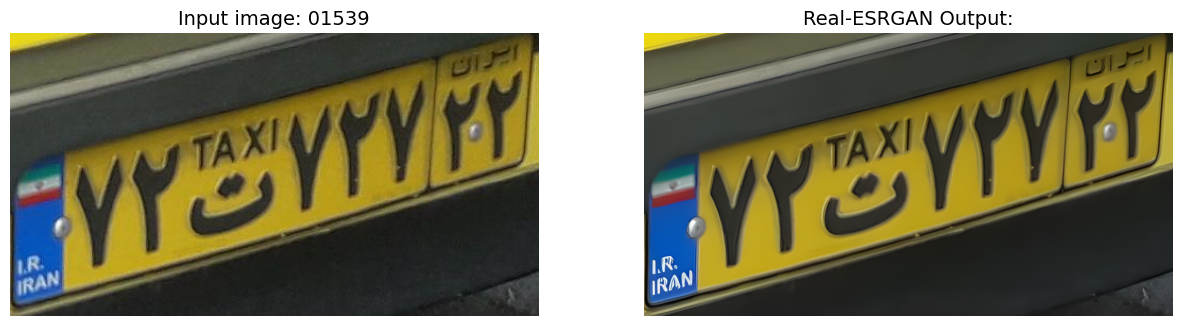

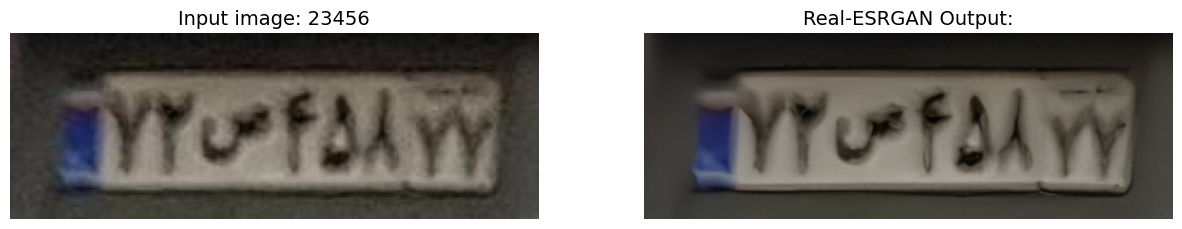

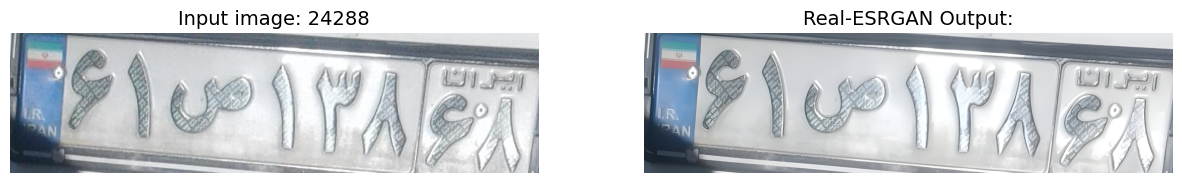

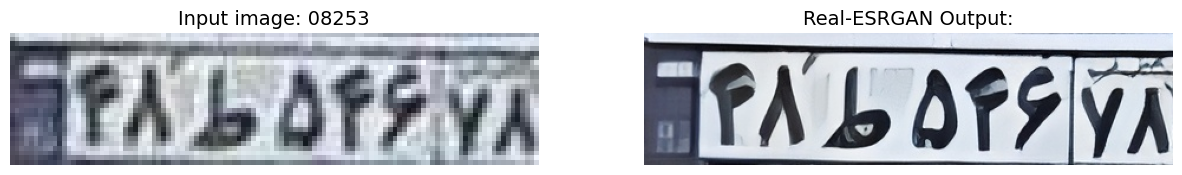

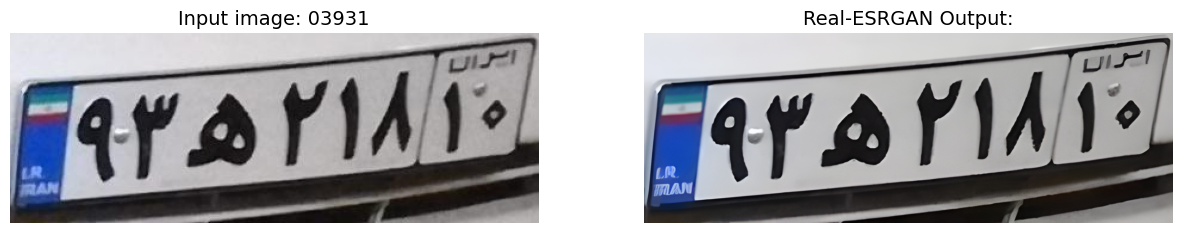

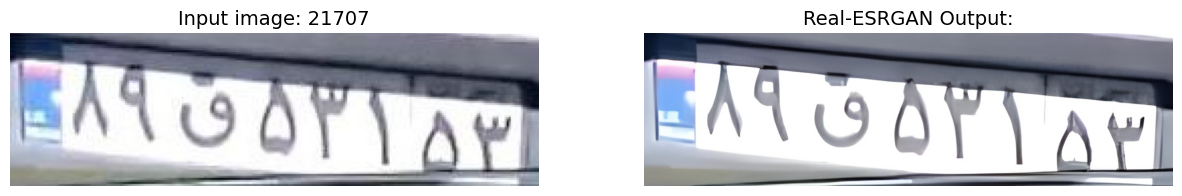

In [20]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt

input_folder = 'upload'
result_folder = 'results'

# تعداد تصاویر تصادفی که می‌خوایم ببینیم
num_samples = 10

# لیست همه تصاویر ورودی
input_list = glob.glob(os.path.join(input_folder, '*.jpg'))
input_sample = random.sample(input_list, min(num_samples, len(input_list)))

# لیست برای نگهداری مسیر جفت‌ها
paired_paths = []

# تابع برای خواندن تصویر
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# تابع نمایش
def display(img1, img2, name):
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img1)
    ax1.set_title('Input image: ' + name, fontsize=14)
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img2)
    ax2.set_title('Real-ESRGAN Output:', fontsize=14)
    ax2.axis('off')
    plt.show()

# برای هر ورودی، خروجی متناظر رو پیدا کن و نمایش بده
for input_path in input_sample:
    base_name = os.path.splitext(os.path.basename(input_path))[0]

    # جستجوی فایل خروجی با همان نام پایه
    candidates = glob.glob(os.path.join(result_folder, base_name + '*'))
    if not candidates:
        print(f'⛔ فایل خروجی برای {base_name} پیدا نشد!')
        continue

    output_path = candidates[0]  # اولین فایل مطابق را در نظر می‌گیریم

    paired_paths.append((input_path, output_path))  # ذخیره مسیر جفت

    img_input = imread(input_path)
    img_output = imread(output_path)
    display(img_input, img_output, base_name)

# 5. Measurement criteria

**1.   NIQE(Naturalness Image Quality Evaluator)**

In [21]:
from basicsr.metrics.niqe import calculate_niqe
from PIL import Image
import numpy as np
import os
import glob

def get_niqe_basicsr(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((512, 512))
    img_np = np.array(img)
    return calculate_niqe(img_np, crop_border=0)

niqe_inputs = []
niqe_outputs = []

print("🔍 NIQE برای تصاویر انتخاب‌شده (paired_paths):\n" + "="*50)

for input_path, output_path in paired_paths:
    try:
        niqe_in = get_niqe_basicsr(input_path)
        niqe_out = get_niqe_basicsr(output_path)
        niqe_inputs.append(niqe_in)
        niqe_outputs.append(niqe_out)

        status = "✅ بهبود" if niqe_out < niqe_in else "🔻 پسرفت"
        print(f"📸 {os.path.basename(input_path)}")
        print(f"    Input NIQE : {niqe_in:.2f}")
        print(f"    Output NIQE: {niqe_out:.2f}")
        print(f"    🔎 نتیجه: {status}")
        print('-' * 40)

    except Exception as e:
        print(f"⛔ خطا در پردازش {input_path}: {e}")

# میانگین NIQE برای paired_paths
mean_niqe_in = sum(niqe_inputs) / len(niqe_inputs)
mean_niqe_out = sum(niqe_outputs) / len(niqe_outputs)
overall_result = "✅ بهبود کلی" if mean_niqe_out < mean_niqe_in else "🔻 افت کلی"

print("\n📊 میانگین NIQE برای تصاویر انتخاب‌شده:")
print(f"    Input Mean NIQE : {mean_niqe_in:.2f}")
print(f"    Output Mean NIQE: {mean_niqe_out:.2f}")
print(f"    🔎 نتیجه کلی: {overall_result}")
print("=" * 50)

🔍 NIQE برای تصاویر انتخاب‌شده (paired_paths):
📸 03474.jpg
    Input NIQE : 9.72
    Output NIQE: 7.12
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 24280.jpg
    Input NIQE : 8.67
    Output NIQE: 7.37
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 26778.jpg
    Input NIQE : 7.18
    Output NIQE: 6.00
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 19784.jpg
    Input NIQE : 10.37
    Output NIQE: 7.80
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 01539.jpg
    Input NIQE : 7.14
    Output NIQE: 8.82
    🔎 نتیجه: 🔻 پسرفت
----------------------------------------
📸 23456.jpg
    Input NIQE : 10.57
    Output NIQE: 8.15
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 24288.jpg
    Input NIQE : 7.10
    Output NIQE: 6.91
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 08253.jpg
    Input NIQE : 10.55
    Output NIQE: 6.86
    🔎 نتیجه: ✅ بهبود
----------------------------------------
📸 03931

**2. OCR Model**

I used https://huggingface.co/hezarai/crnn-fa-license-plate-recognition-v2 to read persian license plates.

In [8]:
!pip install hezar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 8.9 MB/s eta 0:00:00


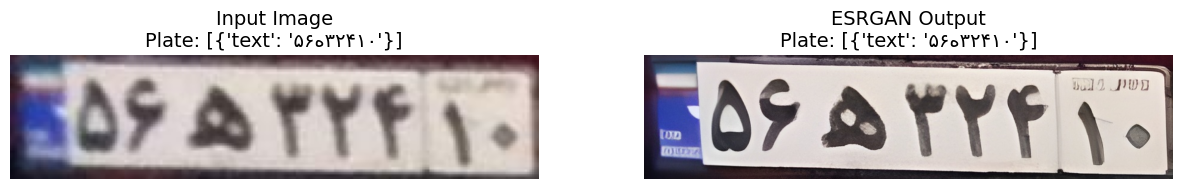

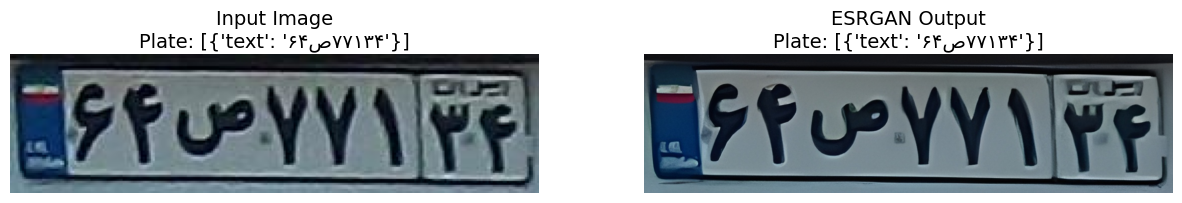

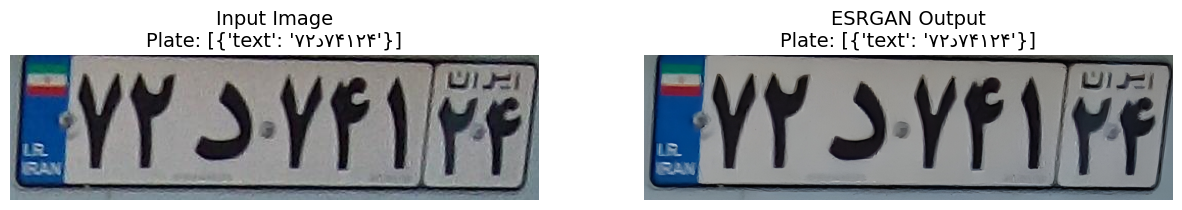

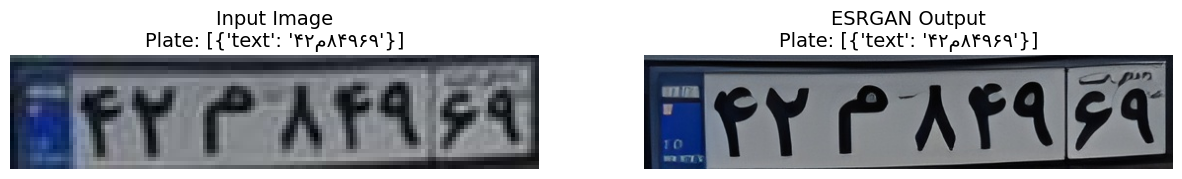

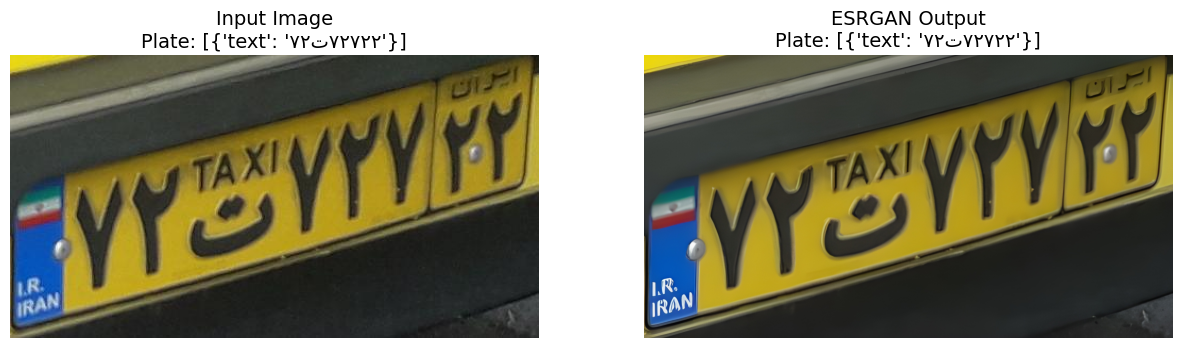

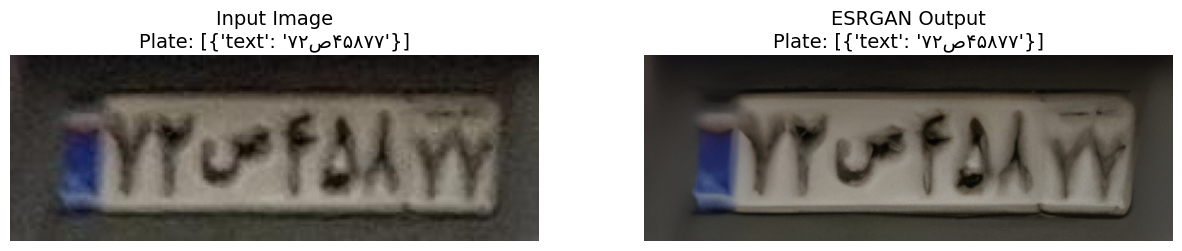

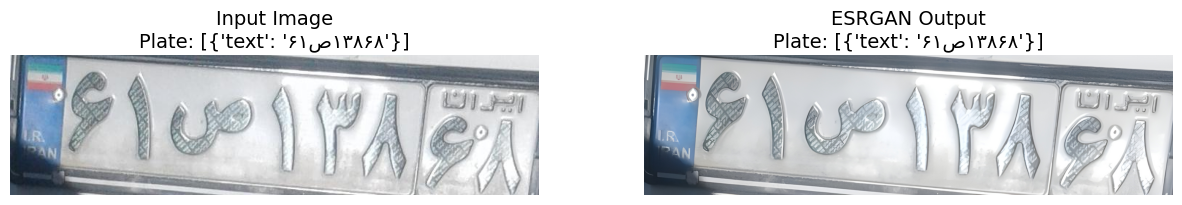

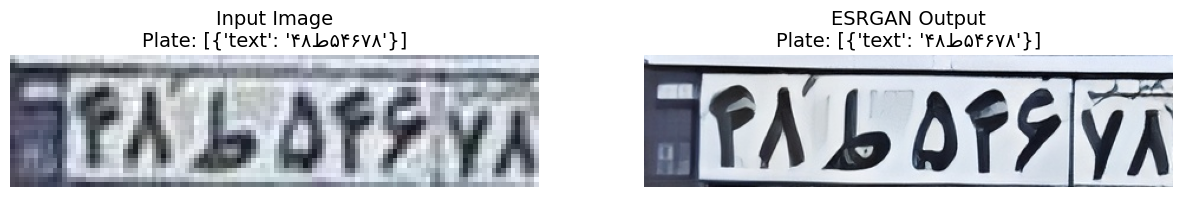

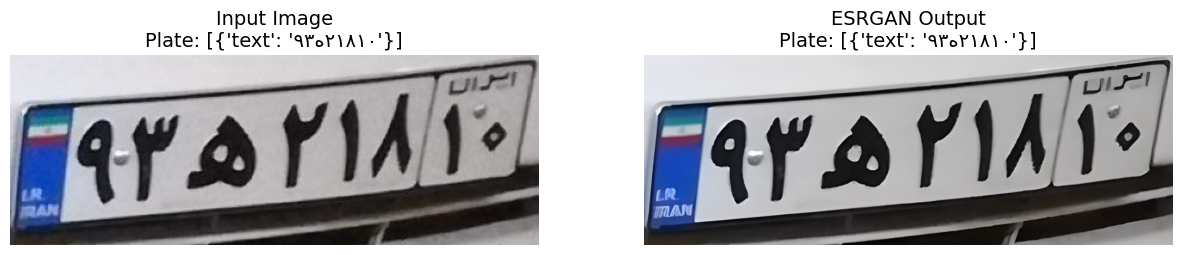

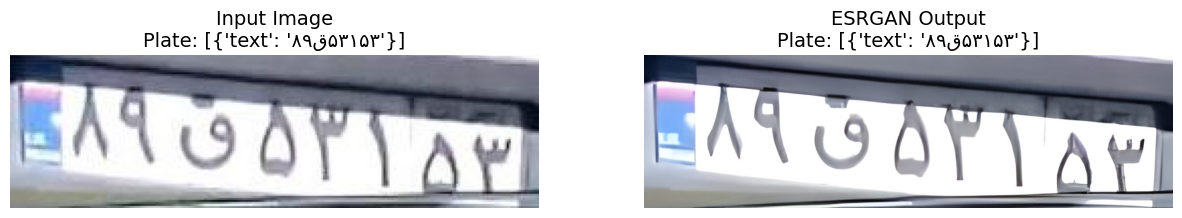

In [22]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
from hezar.models import Model

#lp_ocr = Model.load("hezarai/crnn-fa-64x256-license-plate-recognition")
lp_ocr = Model.load("hezarai/crnn-fa-license-plate-recognition-v2")


# تابع خواندن تصویر
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# نمایش تصاویر و خروجی مدل
for input_path, output_path in paired_paths:
    # خواندن تصاویر
    img_input = imread(input_path)
    img_output = imread(output_path)

    # تشخیص پلاک
    plate_input = lp_ocr.predict(img_input)
    plate_output = lp_ocr.predict(img_output)

    # نمایش تصاویر
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img_input)
    ax1.set_title(f"Input Image\nPlate: {plate_input}", fontsize=14)
    ax1.axis('off')

    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img_output)
    ax2.set_title(f"ESRGAN Output\nPlate: {plate_output}", fontsize=14)
    ax2.axis('off')

    plt.show()

# 6. Dowmload input and output

In [24]:
from google.colab import files
# Download the upload
zip_filename = 'Real-ESRGAN_upload.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} upload/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Download the results
zip_filename = 'Real-ESRGAN_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>